In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [13]:
# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [14]:
csv_file_path = '/content/drive/MyDrive/train.csv'

df = pd.read_csv(csv_file_path)
print("Number of samples in dataset:", len(df))
# df = df.sample(n=1000, random_state=42)


# Step 2: Define image paths and labels
image_dir = {
    '0': '/content/drive/MyDrive/colored_images/No_DR',
    '1': '/content/drive/MyDrive/colored_images/Mild',
    '2': '/content/drive/MyDrive/colored_images/Moderate' ,
    '3': '/content/drive/MyDrive/colored_images/Severe',
    '4': '/content/drive/MyDrive/colored_images/Proliferate_DR'
}
image_paths = []
labels = []

# Assuming the CSV has 'filename' and 'label' columns
for idx, row in df.iterrows():
    filename = row['id_code']
    label = row['diagnosis']
    # Add .png extension to filename
    # Make sure the filenames in your CSV match the actual filenames in your folders, including the extension.
    image_path = os.path.join(image_dir[str(label)], filename + ".png")

    # Check if the image file actually exists
    if os.path.exists(image_path):
        image_paths.append(image_path)
        labels.append(label)
    else:
        print(f"Warning: Image file not found: {image_path}")

# Step 3: Preprocess the images
def preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for image_path in image_paths:
        img = load_img(image_path, target_size=target_size)
        img = img_to_array(img) # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)

# Convert images to numpy arrays
X = preprocess_images(image_paths)

# Convert labels to a numpy array and one-hot encode them
y = np.array(labels)
y = to_categorical(y, num_classes=5)  # 5 classes: 0 to 4

Number of samples in dataset: 3662


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
from tensorflow.keras.applications.efficientnet import preprocess_input

# After loading and resizing your images into arrays:
# X_train, X_val, X_test should be float32 and in range [0, 255]

# Optional: If not already float32
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
# X_test = X_test.astype('float32')

# Preprocess using EfficientNet's recommended preprocessing
X_train = preprocess_input(X_train)
X_val = preprocess_input(X_val)
# X_test = preprocess_input(X_test)



In [16]:
def create_transfer_model(input_shape=(224, 224, 3), fine_tune_at=200):
    base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Enable fine-tuning

    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy' , metrics=['accuracy'])

    return model

model = create_transfer_model()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 71s 391ms/step - accuracy: 0.5724 - loss: 1.1203 - val_accuracy: 0.7353 - val_loss: 0.7058
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 33s 63ms/step - accuracy: 0.7463 - loss: 0.6692 - val_accuracy: 0.7913 - val_loss: 0.5700
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8059 - loss: 0.5440 - val_accuracy: 0.8131 - val_loss: 0.5158
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8246 - loss: 0.4819 - val_accuracy: 0.8226 - val_loss: 0.5085
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - accuracy: 0.8451 - loss: 0.4250 - val_accuracy: 0.8363 - val_loss: 0.4891
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.8446 - loss: 0.4221 - val_accuracy: 0.8322 - val_loss: 0.4847
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.8714 - loss: 0.3621 - val_accuracy: 0.8390 - val_loss: 0.4798
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.8827 - loss: 0.3196 - val_accuracy: 0.82

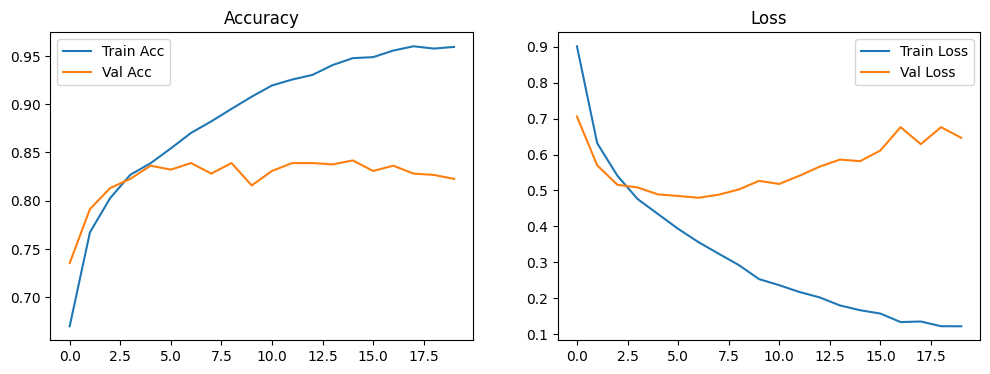

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_history(history)


In [19]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7929 - loss: 0.7309
Validation Accuracy: 0.8226


In [20]:
from sklearn.metrics import classification_report
import numpy as np

# Convert one-hot encoded y_val to class labels
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(model.predict(X_val), axis=1)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=[
    'No_DR (0)', 'Mild (1)', 'Moderate (2)', 'Severe (3)', 'Proliferate_DR (4)'
])

print("Classification Report:\n")
print(report)


23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step
Classification Report:

                    precision    recall  f1-score   support

         No_DR (0)       0.98      0.98      0.98       361
          Mild (1)       0.62      0.61      0.62        74
      Moderate (2)       0.77      0.75      0.76       200
        Severe (3)       0.47      0.44      0.45        39
Proliferate_DR (4)       0.54      0.61      0.57        59

          accuracy                           0.82       733
         macro avg       0.68      0.68      0.68       733
      weighted avg       0.82      0.82      0.82       733



23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


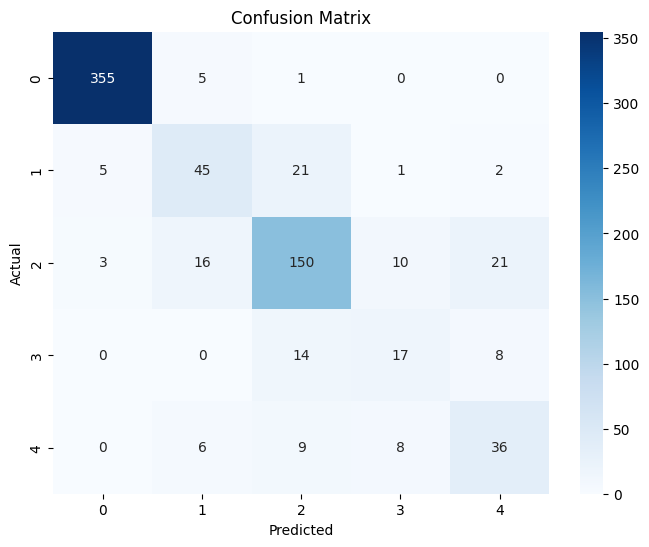

Classification Report:
               precision    recall  f1-score   support

           0     0.9780    0.9834    0.9807       361
           1     0.6250    0.6081    0.6164        74
           2     0.7692    0.7500    0.7595       200
           3     0.4722    0.4359    0.4533        39
           4     0.5373    0.6102    0.5714        59

    accuracy                         0.8226       733
   macro avg     0.6763    0.6775    0.6763       733
weighted avg     0.8230    0.8226    0.8225       733

Accuracy: 0.8226


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Get predicted labels (as class indices)
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification metrics
report = classification_report(y_true, y_pred, digits=4)
print("Classification Report:\n", report)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")


In [22]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,170,196 (31.17 MB)

 Trainable params: 2,057,109 (7.85 MB)

 Non-trainable params: 1,998,867 (7.63 MB)

 Optimizer params: 4,114,220 (15.69 MB)

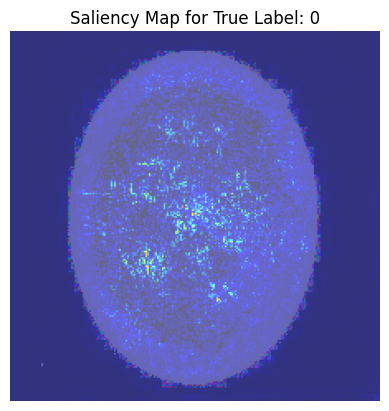

In [23]:
import tensorflow.keras.backend as K

# Pick one sample from validation set to visualize
index = 10  # change as needed
image = X_val[index:index+1]
true_label = y_true[index]

# Use GradientTape to compute gradients
image_tensor = tf.convert_to_tensor(image)
with tf.GradientTape() as tape:
    tape.watch(image_tensor)
    preds = model(image_tensor)
    top_class = tf.argmax(preds[0])
    loss = preds[:, top_class]

# Compute gradient of loss w.r.t. input image
grads = tape.gradient(loss, image_tensor)[0]
grads = tf.reduce_max(tf.abs(grads), axis=-1)

# Normalize for visualization
grads = (grads - tf.reduce_min(grads)) / (tf.reduce_max(grads) - tf.reduce_min(grads))

plt.imshow(image[0] / 2 + 0.5)  # un-normalize the image if needed
plt.imshow(grads, cmap='jet', alpha=0.6)
plt.title(f"Saliency Map for True Label: {true_label}")
plt.axis('off')
plt.show()


In [25]:
# Print all layer names in the model
for i, layer in enumerate(model.layers):
    print(f"{i}: {layer.name}")


0: input_layer_1
1: efficientnetb0
2: global_average_pooling2d
3: dropout
4: dense
